In [1]:
import os
import sys
import json
import glob
import torch 
import numpy as np
sys.path.append("..")

from src.eeg_to_audio.utils.data import TaskDataset
from src.eeg_to_audio.models.models import Model
import torch.nn.functional as F

Гиперпараметры

In [2]:
# Размер батча
batch_size = 64

# Длина окна
window_length_seconds = 5 
sample_rate = 64
window_length = window_length_seconds * sample_rate

# Расстояние между двумя окнами
hop_length_seconds = 1
hop_length = sample_rate * hop_length_seconds

# Количество ложных стимулов
number_of_mismatch = 4

max_files = None

Подготовим данные для обучения и тестирования моделей

In [3]:
# Путь к директории проекта
project_path = os.path.dirname(os.path.abspath(""))
preds_path = os.path.join(project_path, "code/predictions")
os.makedirs(preds_path, exist_ok=True)

# Загрузим конфигурационный файл
with open(os.path.join(project_path, "src/mylib/utils/config.json")) as file_path:
    config = json.load(file_path)

# Путь к набору данных, который уже разделен на train, test
data_folder = os.path.join(config["dataset_folder"], config['derivatives_folder'], config["split_folder"])

# Тренировочные данные
train_files = [x for x in glob.glob(os.path.join(data_folder, "train_-_*")) if
                       os.path.basename(x).split("_-_")[-1].split(".")[0] in ["eeg", "envelope"]]

# Тестовые данные
test_files = [x for x in glob.glob(os.path.join(data_folder, "test_-_*")) if
                       os.path.basename(x).split("_-_")[-1].split(".")[0] in ["eeg", "envelope"]]

# Разделение на субъекты/участники
subjects = list(set([os.path.basename(x).split("_-_")[1] for x in test_files]))

Dataloader для обучения моделей

In [4]:
train_dataloader = torch.utils.data.DataLoader(
    TaskDataset(train_files, window_length, hop_length, number_of_mismatch, max_files=max_files), 
    batch_size=batch_size)

Функции для обучения 

In [5]:
from torch.utils.tensorboard import SummaryWriter


def train_one_epoch(model, epoch_index, writer, optimizer, loss_fn):
    """Обучение на одной эпохе"""

    running_loss = 0
    last_loss = 0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            x = epoch_index * len(train_dataloader) + i + 1
            writer.add_scalar('Loss/train', last_loss, x)
            running_loss = 0

    return last_loss

def train_model(model, epochs, run_name, optimizer, loss_fn):
    """Обучение модели"""

    writer = SummaryWriter(f"runs/{run_name}")

    if not os.path.isdir("saved_models"):
        os.makedirs("saved_models")
    
    model.train()
    for epoch in range(epochs):
        print(f"EPOCH {epoch + 1}:")
        
        avg_loss = train_one_epoch(model, epoch + 1, writer, optimizer, loss_fn)

        print(f"LOSS train {avg_loss}")
        writer.add_scalar("Training", avg_loss, epoch + 1)
        writer.flush()

        model_path = f"saved_models/{run_name}_{epoch + 1}"
        torch.save(model.state_dict(), model_path)
        
def test_model(model, name, use_embeddings, embedding_type):
    accuracies = []
    model.eval()
    with torch.no_grad():
        for sub in subjects:
            sub_test_files = [f for f in test_files if sub in os.path.basename(f)]
            sub_dataset = TaskDataset(
                files=sub_test_files, 
                window_length=window_length, 
                hop_length=hop_length,
                number_of_mismatch=number_of_mismatch, 
                max_files=None, 
                use_embeddings=use_embeddings, 
                embedding_type=embedding_type
            )
            test_dataloader = torch.utils.data.DataLoader(sub_dataset, batch_size=1)
            loss = 0
            correct = 0
            for inputs, label in test_dataloader:
                outputs = model(inputs)
                loss += F.cross_entropy(outputs, label).item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == label).long().item()
                
            mean_per_sub = correct / len(test_dataloader)
            accuracies.append(mean_per_sub)
    results_path = os.path.join(preds_path, f"{name}.json")
    with open(results_path, "w") as f:
        json.dump(accuracies, f)
    return accuracies
        
def find_best_model(model, prefix, use_embeddings, embedding_type):
    best_model_idx = 1
    best_mean_accuracy = 0
    for i in range(10): # количество эпох
        model_path = f"{prefix}_{i + 1}"
        model_name = os.path.basename(model_path)
        model.load_state_dict(torch.load(model_path))
        print(f"Testing {os.path.basename(model_name)}")
        accuracies = test_model(model, model_name, use_embeddings, embedding_type)
        print(f"    Score: {np.mean(accuracies) * 100}")
        print(f"    Standard deviation: {np.std(accuracies) * 100}")
        if np.mean(accuracies) > best_mean_accuracy:
            best_mean_accuracy = np.mean(accuracies)
            best_model_idx = i + 1
    print(f"Best model: {prefix}_{best_model_idx}")
    print(f"Best mean accuracy over subjects: {best_mean_accuracy * 100}")

2024-04-23 19:39:40.850329: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 19:39:42.255194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Обучение моделей

## Базовое решение 

In [6]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
train_model(model, 10, "Baseline", optimizer, loss_fn)

EPOCH 1:
  batch 1000 loss: 1.4236116971969603
  batch 2000 loss: 1.3350688633173704
  batch 3000 loss: 1.2263945920690895
  batch 4000 loss: 1.1100922726839781
  batch 5000 loss: 1.1574973969608546
  batch 6000 loss: 1.0699141708165407
  batch 7000 loss: 0.9060650415495038
  batch 8000 loss: 0.8751413805114571
  batch 9000 loss: 0.8953722582366318
LOSS train 0.8953722582366318
EPOCH 2:
  batch 1000 loss: 1.2430362387001515
  batch 2000 loss: 1.0368988644480706
  batch 3000 loss: 1.0211635073125362
  batch 4000 loss: 0.9859314801990986
  batch 5000 loss: 1.074497663706541
  batch 6000 loss: 0.9084391695093363
  batch 7000 loss: 0.7152104988954961
  batch 8000 loss: 0.8110165086437482
  batch 9000 loss: 0.7241114568758349
LOSS train 0.7241114568758349
EPOCH 3:
  batch 1000 loss: 1.204264582335949
  batch 2000 loss: 0.970810384966433
  batch 3000 loss: 1.0264518781602383
  batch 4000 loss: 0.9271645446121692
  batch 5000 loss: 1.0622857927083968
  batch 6000 loss: 0.9164367970526218
  ba

## Трансформер-кодировщик

In [6]:
model = Model(use_transformer=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
train_model(model, 10, "Transformer", optimizer, loss_fn)

EPOCH 1:


/home/bukkacha/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  batch 1000 loss: 1.478800526380539
  batch 2000 loss: 1.4153387330174445
  batch 3000 loss: 1.2953025230169297
  batch 4000 loss: 1.2047291131913662
  batch 5000 loss: 1.2352882451713085
  batch 6000 loss: 1.149226269185543
  batch 7000 loss: 0.9131390470564366
  batch 8000 loss: 0.9533479110375047
  batch 9000 loss: 0.8801870014816523
LOSS train 0.8801870014816523
EPOCH 2:
  batch 1000 loss: 1.3204181343317032
  batch 2000 loss: 1.1332785344421863
  batch 3000 loss: 1.1625599875301122
  batch 4000 loss: 1.060022843196988
  batch 5000 loss: 1.1211522375941276
  batch 6000 loss: 0.9693181176781654
  batch 7000 loss: 0.7233105075024069
  batch 8000 loss: 0.8794877903144807
  batch 9000 loss: 0.7624318301044405
LOSS train 0.7624318301044405
EPOCH 3:
  batch 1000 loss: 1.2457961226701737
  batch 2000 loss: 1.0385510069206356
  batch 3000 loss: 1.066134143039584
  batch 4000 loss: 0.9746390198022127
  batch 5000 loss: 1.0916806876957417
  batch 6000 loss: 0.9601199959143997
  batch 7000 l

## Wav2Vec2

In [5]:
train_dataloader = torch.utils.data.DataLoader(
    TaskDataset(
        train_files, 
        window_length, 
        hop_length, 
        number_of_mismatch, 
        use_embeddings=True,
        embedding_type="wav2vec",
        max_files=max_files
    ), 
    batch_size=batch_size)

In [6]:
model = Model(use_embeddings=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
train_model(model, 10, "Wav2Vec2", optimizer, loss_fn)

EPOCH 1:
  batch 1000 loss: 1.3662997370362282
  batch 2000 loss: 1.3435519411116839
  batch 3000 loss: 1.231669880270958
  batch 4000 loss: 1.1406536244452
  batch 5000 loss: 1.2572615306079387
  batch 6000 loss: 1.0864462063163518
  batch 7000 loss: 0.947474068036303
  batch 8000 loss: 0.9424286197645124
  batch 9000 loss: 0.8118643170073628
LOSS train 0.8118643170073628
EPOCH 2:
  batch 1000 loss: 1.272037116199732
  batch 2000 loss: 1.0826246792450547
  batch 3000 loss: 0.9904180364981293
  batch 4000 loss: 0.9230534630846232
  batch 5000 loss: 1.0704123395681382
  batch 6000 loss: 0.9424439346529543
  batch 7000 loss: 0.753140829268843
  batch 8000 loss: 0.940974034695886
  batch 9000 loss: 0.7553026258163155
LOSS train 0.7553026258163155
EPOCH 3:
  batch 1000 loss: 1.2101848999261855
  batch 2000 loss: 1.0929499887935816
  batch 3000 loss: 1.0496226754039526
  batch 4000 loss: 0.9977835546210408
  batch 5000 loss: 1.1074906907081603
  batch 6000 loss: 0.9139102460853755
  batch 7

## Wav2Vec2 + Трансформер-кодировщик

In [6]:
model = Model(use_transformer=True, use_embeddings=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
train_model(model, 10, "Wav2Vec2_Transformer", optimizer, loss_fn)

EPOCH 1:


/home/bukkacha/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  batch 1000 loss: 1.4447205238938332
  batch 2000 loss: 1.4130910626649857
  batch 3000 loss: 1.2888768396973609
  batch 4000 loss: 1.2102454049885274
  batch 5000 loss: 1.299887429535389
  batch 6000 loss: 1.2342196773290635
  batch 7000 loss: 1.0774298080429434
  batch 8000 loss: 1.0283029739372431
  batch 9000 loss: 0.9198296899050474
LOSS train 0.9198296899050474
EPOCH 2:
  batch 1000 loss: 1.291153755068779
  batch 2000 loss: 1.2350445881485939
  batch 3000 loss: 1.1618102525621652
  batch 4000 loss: 1.1117135928571225
  batch 5000 loss: 1.223812633961439
  batch 6000 loss: 1.1147157388329505
  batch 7000 loss: 0.9200177744477988
  batch 8000 loss: 0.9740746207442135
  batch 9000 loss: 0.8489593121334911
LOSS train 0.8489593121334911
EPOCH 3:
  batch 1000 loss: 1.219773182928562
  batch 2000 loss: 1.1385985208451748
  batch 3000 loss: 1.0581673898249864
  batch 4000 loss: 1.0140426948070527
  batch 5000 loss: 1.1334198258966208
  batch 6000 loss: 0.9884603485614062
  batch 7000 l

## Whisper

In [5]:
train_dataloader = torch.utils.data.DataLoader(
    TaskDataset(
        train_files, 
        window_length, 
        hop_length, 
        number_of_mismatch, 
        use_embeddings=True,
        embedding_type="whisper",
        max_files=max_files
    ), 
    batch_size=batch_size)

In [7]:
model = Model(use_embeddings=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
train_model(model, 10, "Whisper", optimizer, loss_fn)

EPOCH 1:
  batch 1000 loss: 1.530054544687271
  batch 2000 loss: 1.5085525208413602
  batch 3000 loss: 1.388169602394104
  batch 4000 loss: 1.3246328034996986
  batch 5000 loss: 1.3454550401270389
  batch 6000 loss: 1.322010199278593
  batch 7000 loss: 1.216881231099367
  batch 8000 loss: 1.0325167435631155
  batch 9000 loss: 0.9929398702755571
LOSS train 0.9929398702755571
EPOCH 2:
  batch 1000 loss: 1.3499571793675422
  batch 2000 loss: 1.2822652371823788
  batch 3000 loss: 1.2339162350296975
  batch 4000 loss: 1.1991217382550239
  batch 5000 loss: 1.2615520667135716
  batch 6000 loss: 1.211245310306549
  batch 7000 loss: 0.9937756114900113
  batch 8000 loss: 0.9865182080548257
  batch 9000 loss: 0.8998065079674125
LOSS train 0.8998065079674125
EPOCH 3:
  batch 1000 loss: 1.2882275751829146
  batch 2000 loss: 1.1816454423069953
  batch 3000 loss: 1.1621199712455272
  batch 4000 loss: 1.1194220950603486
  batch 5000 loss: 1.2181407805383206
  batch 6000 loss: 1.1030537429451943
  batc

## Whisper + Трансформер-кодировщик

In [8]:
model = Model(use_transformer=True, use_embeddings=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
train_model(model, 10, "Whisper_Transformer", optimizer, loss_fn)

EPOCH 1:
  batch 1000 loss: 1.4692934195399285
  batch 2000 loss: 1.4516245831251144
  batch 3000 loss: 1.2963569405376911
  batch 4000 loss: 1.2403112150132656
  batch 5000 loss: 1.3123895798027516
  batch 6000 loss: 1.239592512458563
  batch 7000 loss: 1.2398733949661256
  batch 8000 loss: 1.0470608564019204
  batch 9000 loss: 0.8900982885435224
LOSS train 0.8900982885435224
EPOCH 2:
  batch 1000 loss: 1.2603485351800918
  batch 2000 loss: 1.1966750031709672
  batch 3000 loss: 1.1270521369874478
  batch 4000 loss: 1.0945382124856113
  batch 5000 loss: 1.1754349231123924
  batch 6000 loss: 1.0157934419810772
  batch 7000 loss: 0.8412438865676523
  batch 8000 loss: 1.1288031111583114
  batch 9000 loss: 0.964851033680141
LOSS train 0.964851033680141
EPOCH 3:
  batch 1000 loss: 1.174999808192253
  batch 2000 loss: 1.178183576092124
  batch 3000 loss: 1.0567990419715643
  batch 4000 loss: 0.9985540768764913
  batch 5000 loss: 1.1337618932723998
  batch 6000 loss: 0.9582912397235632
  batc

# Тестирование моделей

In [12]:
# Baseline
model = Model()
find_best_model(model, "saved_models/Baseline", use_embeddings=False, embedding_type=None)

Testing Baseline_1
    Score: 39.360677658368246
    Standard deviation: 8.651644625493846
Testing Baseline_2
    Score: 46.66444428993618
    Standard deviation: 11.359896796031574
Testing Baseline_3
    Score: 45.96438560624621
    Standard deviation: 11.182113087018115
Testing Baseline_4
    Score: 46.440096065481924
    Standard deviation: 11.01103218593001
Testing Baseline_5
    Score: 44.80580518390737
    Standard deviation: 10.705961941627889
Testing Baseline_6
    Score: 46.359484367436
    Standard deviation: 11.511476317401828
Testing Baseline_7
    Score: 46.79768675465637
    Standard deviation: 11.489560573190417
Testing Baseline_8
    Score: 47.68028231894928
    Standard deviation: 11.7532132984657
Testing Baseline_9
    Score: 45.818900961757144
    Standard deviation: 10.255576511151649
Testing Baseline_10
    Score: 45.98206954063792
    Standard deviation: 10.364910983815669
Best model: saved_models/Baseline_8
Best mean accuracy over subjects: 47.68028231894928


In [7]:
# transformer
model = Model(use_transformer=True)
find_best_model(model, "saved_models/Transformer", use_embeddings=False, embedding_type=None)

Testing Transformer_1
    Score: 39.0940746710181
    Standard deviation: 6.0620562089009065
Testing Transformer_2
    Score: 42.82136347214697
    Standard deviation: 7.608204772168582
Testing Transformer_3
    Score: 43.86994840651148
    Standard deviation: 8.64796062179662
Testing Transformer_4
    Score: 46.99608369553099
    Standard deviation: 9.69434147599378
Testing Transformer_5
    Score: 47.38630537800766
    Standard deviation: 10.11790195830794
Testing Transformer_6
    Score: 46.81368532476631
    Standard deviation: 9.172093270112075
Testing Transformer_7
    Score: 46.94043750966656
    Standard deviation: 10.050665221015153
Testing Transformer_8
    Score: 48.14620389539536
    Standard deviation: 10.325968545729618
Testing Transformer_9
    Score: 47.76784312538807
    Standard deviation: 10.368920975904734
Testing Transformer_10
    Score: 47.92992166567605
    Standard deviation: 9.996836650151128
Best model: saved_models/Transformer_8
Best mean accuracy over subje

In [14]:
# wav2vec
model = Model(use_embeddings=True)
find_best_model(model, "saved_models/Wav2Vec2", use_embeddings=True, embedding_type="wav2vec")

Testing Wav2Vec2_1
    Score: 41.82758925036238
    Standard deviation: 10.080636249381419
Testing Wav2Vec2_2
    Score: 46.362373542103626
    Standard deviation: 10.871913835124452
Testing Wav2Vec2_3
    Score: 38.70606376805536
    Standard deviation: 7.059814477162425
Testing Wav2Vec2_4
    Score: 45.83871448503402
    Standard deviation: 10.82189235658003
Testing Wav2Vec2_5
    Score: 47.924381652937356
    Standard deviation: 11.538437697974684
Testing Wav2Vec2_6
    Score: 47.82545052845452
    Standard deviation: 11.903177220611463
Testing Wav2Vec2_7
    Score: 44.39463305420997
    Standard deviation: 10.020710351271953
Testing Wav2Vec2_8
    Score: 45.44762857460445
    Standard deviation: 10.048801686961005
Testing Wav2Vec2_9
    Score: 44.0328294023473
    Standard deviation: 9.764226518065867
Testing Wav2Vec2_10
    Score: 43.97768376093069
    Standard deviation: 10.037348620764808
Best model: saved_models/Wav2Vec2_5
Best mean accuracy over subjects: 47.924381652937356


In [6]:
# wav2vec + transformer
model = Model(use_transformer=True, use_embeddings=True)
find_best_model(model, "saved_models/Wav2Vec2_Transformer", use_embeddings=True, embedding_type="wav2vec")

Testing Wav2Vec2_Transformer_1
    Score: 39.22095959597641
    Standard deviation: 7.578864991908082
Testing Wav2Vec2_Transformer_2
    Score: 43.02705780223626
    Standard deviation: 8.559468564404776
Testing Wav2Vec2_Transformer_3
    Score: 45.696212950223256
    Standard deviation: 8.968160150457736
Testing Wav2Vec2_Transformer_4
    Score: 46.1559558269976
    Standard deviation: 9.408322690545964
Testing Wav2Vec2_Transformer_5
    Score: 46.96316553286621
    Standard deviation: 9.780992723900253
Testing Wav2Vec2_Transformer_6
    Score: 48.19426273293928
    Standard deviation: 9.411968383689235
Testing Wav2Vec2_Transformer_7
    Score: 48.69892030159866
    Standard deviation: 9.439039200528606
Testing Wav2Vec2_Transformer_8
    Score: 48.260723004420484
    Standard deviation: 9.46619078038726
Testing Wav2Vec2_Transformer_9
    Score: 47.986688157266784
    Standard deviation: 9.437650927981997
Testing Wav2Vec2_Transformer_10
    Score: 48.438421034094766
    Standard deviat

In [7]:
# whisper 
model = Model(use_embeddings=True)
find_best_model(model, "saved_models/Whisper", use_embeddings=True, embedding_type="whisper")

Testing Whisper_1
    Score: 39.84660788809597
    Standard deviation: 7.2947474042744656
Testing Whisper_2
    Score: 43.735993438818596
    Standard deviation: 8.831191371701143
Testing Whisper_3
    Score: 45.686518112939005
    Standard deviation: 9.082655335555541
Testing Whisper_4
    Score: 46.68009377243776
    Standard deviation: 9.31487373864925
Testing Whisper_5
    Score: 46.62679452747467
    Standard deviation: 8.920854240151153
Testing Whisper_6
    Score: 46.61873055145058
    Standard deviation: 9.11657367637659
Testing Whisper_7
    Score: 47.28265710744356
    Standard deviation: 8.771947626061971
Testing Whisper_8
    Score: 47.44124544095504
    Standard deviation: 9.490552286052582
Testing Whisper_9
    Score: 47.19368303805454
    Standard deviation: 9.295528695858446
Testing Whisper_10
    Score: 48.0394324213252
    Standard deviation: 9.850522191075745
Best model: saved_models/Whisper_10
Best mean accuracy over subjects: 48.0394324213252


In [8]:
# whisper + transformer
model = Model(use_transformer=True, use_embeddings=True)
find_best_model(model, "saved_models/Whisper_Transformer", use_embeddings=True, embedding_type="whisper")

Testing Whisper_Transformer_1
    Score: 43.130965200886976
    Standard deviation: 7.474750364054375
Testing Whisper_Transformer_2
    Score: 44.36198707310336
    Standard deviation: 7.624153534560188
Testing Whisper_Transformer_3
    Score: 46.481840948455954
    Standard deviation: 8.379141407222217
Testing Whisper_Transformer_4
    Score: 47.82768780215764
    Standard deviation: 9.527966293717169
Testing Whisper_Transformer_5
    Score: 47.436809031532604
    Standard deviation: 9.200021856967187
Testing Whisper_Transformer_6
    Score: 47.86471731764808
    Standard deviation: 9.144051575107168
Testing Whisper_Transformer_7
    Score: 47.714506782082026
    Standard deviation: 9.458328558034058
Testing Whisper_Transformer_8
    Score: 48.35524197758893
    Standard deviation: 9.243531524106075
Testing Whisper_Transformer_9
    Score: 47.93589091150331
    Standard deviation: 9.34330270781373
Testing Whisper_Transformer_10
    Score: 47.92263334389318
    Standard deviation: 9.32

Отобразим результаты на графике

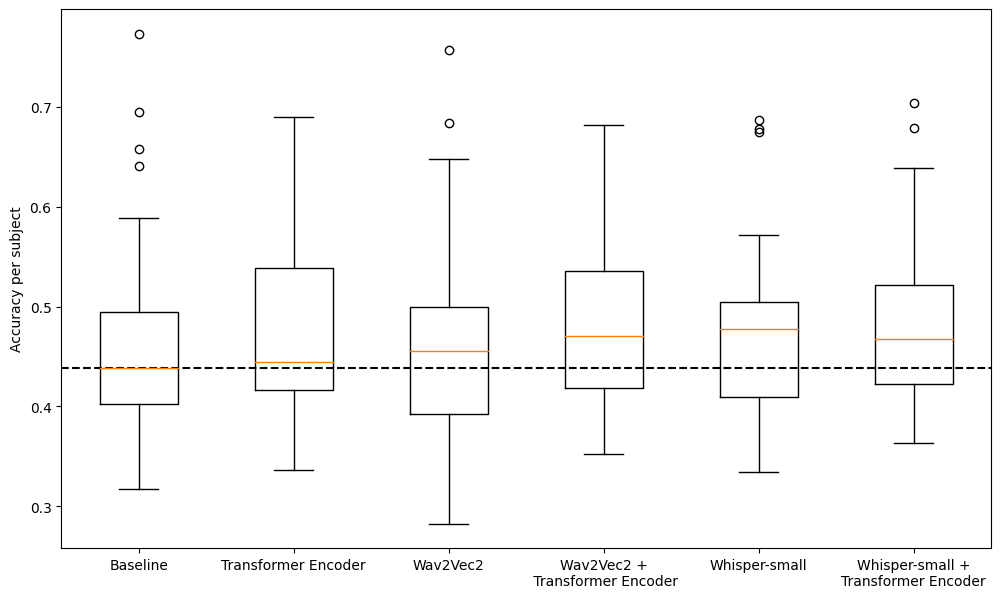

In [37]:
path_to_preds = os.path.join(project_path, "code/predictions")
predictions = []
for model_name in ["Baseline_8", "Transformer_8", "Wav2Vec2_5", "Wav2Vec2_Transformer_7", "Whisper_10", "Whisper_Transformer_8"]:
    with open(os.path.join(path_to_preds, f"{model_name}.json"), "r") as f:
        predictions.append(np.array(json.load(f)))
predictions = np.array(predictions).T
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
plt.boxplot(predictions, labels=["Baseline", "Transformer Encoder", "Wav2Vec2", "Wav2Vec2 +\n Transformer Encoder", "Whisper-small", "Whisper-small +\nTransformer Encoder"])
plt.axhline(y=np.median(predictions.T[0]), linestyle="--", color='black')
plt.ylabel("Accuracy per subject")
plt.show()